### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append(os.path.dirname(os.getcwd()))
sys.path.append(os.getcwd())

import constants
from generic_agents.CodeInterpreterAgent import CodeInterpreterAgent

### Loading the HumanEval Dataset

In [2]:
from human_eval_utils import load_human_eval

dataset = load_human_eval()

print(len(dataset))
task = dataset[-131]
# print a random example
print(task.keys())
print(task['prompt'])
print(task['entry_point'])
# print(task['test'])

164
dict_keys(['task_id', 'prompt', 'canonical_solution', 'test', 'entry_point'])


def sort_third(l: list):
    """This function takes a list l and returns a list l' such that
    l' is identical to l in the indicies that are not divisible by three, while its values at the indicies that are divisible by three are equal
    to the values of the corresponding indicies of l, but sorted.
    >>> sort_third([1, 2, 3])
    [1, 2, 3]
    >>> sort_third([5, 6, 3, 4, 8, 9, 2])
    [2, 6, 3, 4, 8, 9, 5]
    """

sort_third


### Single Agent Coder

#### CodeInterpreterAgent

In [43]:
system_prompt = """ 
    You are an expert software engineer. You are asked to write code to solve a problem 
    which involves creating a Python method to solve a problem indicated as the comments of the method. 
    The code should be efficient and correct. The code should be written in Python. 
    Store the code solution in a file, and provide the file path as the answer.
    Do not add any assertions to the code, just complete the method. 
    Any library imports should be inside the new method, not at the top of the file.
"""

n_problems = 3
single_agent_output_dir = 'CodeGenerations/single_agent_coder'
single_agent_coder = CodeInterpreterAgent(system_prompt=system_prompt, agent_name="single_agent_coder")
print(f'Number of messages: {single_agent_coder.get_number_messages()}')

n_correct = 0
for n_problem in range(n_problems):
    task = dataset[-n_problem]
    
    solution_file_path = os.path.join(single_agent_output_dir, f'problem_{n_problem}.py')
    test_file_save_path = os.path.join(single_agent_output_dir, f'test_{n_problem}.py')

    response = single_agent_coder.prompt_with_output_file(task['prompt'], file_path=solution_file_path)
    code_runs = single_agent_coder.test_human_eval_solutions(solution_file_path=solution_file_path, test_code=task['test'], 
                                        method_name=task['entry_point'], test_file_save_path=test_file_save_path)
    
    print(f'Number of messages: {single_agent_coder.get_number_messages()}')
    print(f'Problem {n_problem} - Tests Passed: {code_runs}')

    if code_runs:
        n_correct += 1
    single_agent_coder.delete_all_messages()

print(f'Correct: {n_correct}/{n_problems}')

Number of messages: 0
Number of messages: 2
Problem 0 - Tests Passed: True
AssertionError in check_code_execution: Test 1
Number of messages: 2
Problem 1 - Tests Passed: False
Number of messages: 2
Problem 2 - Tests Passed: True
Correct: 2/3


#### MultiTurnLLMAgent

In [ ]:
from generic_agents.MultiTurnLLMAgent import MultiTurnLLMAgent
from human_eval_utils import parse_python_code, construct_test_program, code_runs_without_errors, save_results

system_prompt = """ 
    You are an expert software engineer. You are asked to write code to solve a problem 
    which involves creating a Python method to solve a problem indicated as the comments of the method. 
    You should only output the completition of the method, not the entire file.
"""

agent = MultiTurnLLMAgent(system_prompt=system_prompt)
n_tasks = len(dataset)
results = {
    "score": 0, 
    "test_counts": {"NoError": 0, "Error": 0, "AssertionError": 0, "IncorrectInput": 0}, 
    "tests_results": {}
}

n_correct = 0
for task_number in range(n_tasks):
    task = dataset[task_number]
    
    response = agent.user_prompt(task['prompt'])
    completion = parse_python_code(response)

    test_path = constants.HUMAN_EVAL_SINGLE_AGENT_DIR + 'test_files/' + f'problem_{task_number}.py'
    test_program = construct_test_program(task['prompt'], completion, task['test'], task['entry_point'], save_path=test_path)
    (code_works, reason) = code_runs_without_errors(file_path=test_path)
    
    print(f'Problem {task_number} - Tests Passed: {code_works}')
    if code_works:
        n_correct += 1
    if reason in results["test_counts"]:
        results["test_counts"][reason] += 1
    else:
        results["test_counts"][reason] = 1
    results["tests_results"][task_number] = (code_works, reason)

    agent.reset_messages()

results["score"] = round(n_correct/n_tasks * 100, 4)
save_results(results, constants.HUMAN_EVAL_SINGLE_AGENT_DIR)
print(f'Correct: {n_correct}/{n_tasks}')
print(results)

### LangChain AgentCoder

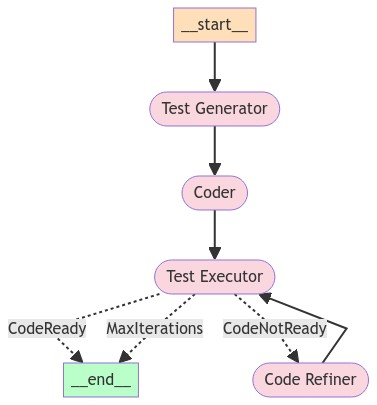

In AgentTestGenerator
Event: {'Test Generator': {'incomplete_method': 'from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n    """ Check if in given list of numbers, are any two numbers closer to each other than\n    given threshold.\n    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n    False\n    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n    True\n    """\n', 'generated_tests': '\nassert has_close_elements([1.0, 2.0, 3.0], 0.5) == False, "Test Case 1: No close elements within threshold"\nassert has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3) == True, "Test Case 2: There are close elements within threshold"\nassert has_close_elements([1.5, 1.6, 2.5], 0.1) == True, "Test Case 3: Close elements 1.5 and 1.6 within threshold of 0.1"\nassert has_close_elements([0.0, 1.0, 2.0, 3.0], 0.9) == False, "Test Case 4: No close elements within threshold of 0.9"\nassert has_close_elements([-1.0, -1.05, -2.0], 0.1) == True, 

In [3]:
from multi_agent_graph import get_multi_agent_summarizer_graph
from IPython.display import Image, display

# task = dataset[145]
task = dataset[0]
max_iterations = 3

config = {"recursion_limit": 50}
inputs = {
    "incomplete_method": task['prompt'],
    "max_iterations": max_iterations,
}

graph = get_multi_agent_summarizer_graph()
app = graph.compile()
display(Image(app.get_graph(xray=True).draw_mermaid_png())) 

for event in app.stream(inputs, config=config):
    print("Event:", event)

In [24]:
last_event_name = list(event.keys())[0]
print(event[last_event_name]['completed_method'])



from typing import List

def has_close_elements(numbers: List[float], threshold: float) -> bool:
    """ Check if in given list of numbers, are any two numbers closer to each other than
    given threshold.
    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)
    False
    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)
    True
    """
    for idx, elem in enumerate(numbers):
        for idx2, elem2 in enumerate(numbers):
            if idx != idx2:
                distance = abs(elem - elem2)
                if distance < threshold:
                    return True

    return False

